# Figures for the general GLQ approach

This notebook makes the figures for the general GLQ approach.

## Provenance information

Load libraries and print the version information.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__  import division
from tempfile import NamedTemporaryFile
from StringIO import StringIO
import numpy as np
from IPython.display import Image
from matplotlib.font_manager import FontProperties
from fatiando.mesher import Tesseroid
from fatiando.constants import MEAN_EARTH_RADIUS
from fatiando.vis import myv, mpl
import fatiando

/Users/deng/anaconda/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")
/Users/deng/anaconda/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


We'll make the graphics using the plotting functions in [Fatiando a Terra](http://www.fatiando.org).

In [2]:
print('Fatiando a Terra version: {}'.format(fatiando.__version__))

Fatiando a Terra version: 0.5


In [3]:
!tessgzzz --version

201809

We'll set the general style of matplotlib here so that we don't have to tweak this for every plot.

In [4]:
mpl.rc('font', size=8, family='Arial')

## Effect of distance and number of GLQ nodes on the computed effects $V_{xyz}$

The code below computes the $V_{xyz}$ effect of a tesseroid on a regular grid with varying height and number of GLQ nodes.

First, we set the dimensions of the tesseroid and write that to a temporary file.

In [5]:
tess_area = (-52, -45, -23, -16)

In [6]:
modelfile = NamedTemporaryFile(delete=False)
modelfile.write('{} {} {} {} 0 -20000 2670'.format(*tess_area))
modelfile.close()
print(modelfile.name)

/var/folders/vp/y3stc73j03ndzq1x99l2bwxw0000gn/T/tmpiD0Mqz


Next, we assemble a pipeline on a string that will use `tessgrd` to create a regular grid and pipe that to `tessgxyz` to calculate the effect.

In [7]:
area = (-70, -30, -35, 0)
shape = (100, 100)
pipeline = ' | '.join(
    ['tessgrd -r{area[0]}/{area[1]}/{area[2]}/{area[3]} -b{shape[0]}/{shape[1]} -z{height}',
     'tessgxyz {model} -a -o{order:d}/{order:d}/{order:d}'])

Now we can insert the computation parameters on the string and execute it in the shell using IPython's `!` syntax.
Then, we capture the stdout in `data` and load the data in numpy arrays using `loadtxt` and some `StringIO` magic.

In [8]:
cmd = pipeline.format(area=area, shape=shape, height=400e03, order=2, model=modelfile.name)
data = !$cmd
high = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

In [9]:
cmd = pipeline.format(area=area, shape=shape, height=150e03, order=2, model=modelfile.name)
data = !$cmd
low = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

In [10]:
high_order = 30
cmd = pipeline.format(area=area, shape=shape, height=400e03, order=high_order, 
                      model=modelfile.name)
data = !$cmd
low_highorder_c = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

In [11]:
high_order = 30
cmd = pipeline.format(area=area, shape=shape, height=150e03, order=high_order, 
                      model=modelfile.name)
data = !$cmd
low_highorder = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

In [12]:
high_order1 = 60
cmd = pipeline.format(area=area, shape=shape, height=800e03, order= high_order1,
                     model=modelfile.name)
data = !$cmd
low_highorder1= np.loadtxt(StringIO('\n'.join(data)), unpack=True)

Now all that's left is to make the figure and save it as EPS.

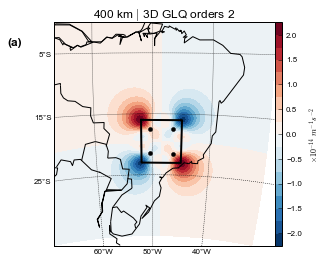

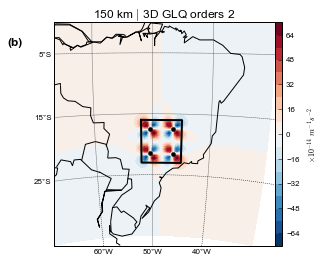

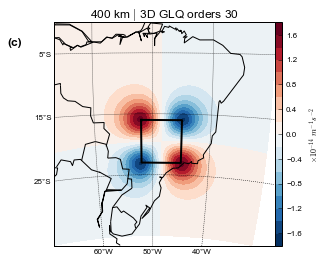

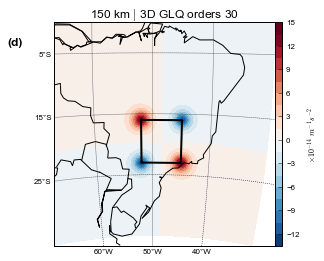

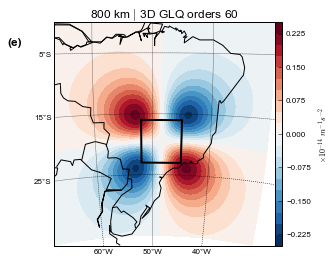

In [13]:
grids = [high, low, low_highorder_c, low_highorder,low_highorder1]
orders = [2, 2, high_order, high_order, high_order1]

bm = mpl.basemap(area, projection='poly')

w, e, s, n = tess_area
# To plot the outline of the tesseroid
tx, ty = bm([w, e, e, w, w], [n, n, s, s, n])
# Scale and make a list of the 2x2 GLQ nodes
nodes = np.array([-0.577350269, 0.577350269])
nodes_lon = 0.5*(e - w)*nodes + 0.5*(e + w)
nodes_lat = 0.5*(n - s)*nodes + 0.5*(n + s)
nodex, nodey = bm(*np.meshgrid(nodes_lon, nodes_lat))

subfigure = ['(a)', '(b)', '(c)','(d)','(e)']

for order, grid, sub in zip(orders, grids, subfigure):
    plt.figure(figsize=(5, 4))
    ax = plt.subplot(111)
    lon, lat, h, g = grid
    unit=10**5
    g = g*unit
    ax.set_title('{:.0f} km $|$ 3D GLQ orders {}'.format(h[0]/1000, order),
                 fontsize=12)
    ax.text(-0.21, 0.9, sub, fontsize=12, fontdict={'weight': 'bold'},#weight
            transform=ax.transAxes)
    vmax = np.abs(g).max()
    vmin = -vmax
    mpl.contourf(lon, lat, g, shape, 20, vmin=vmin, vmax=vmax, basemap=bm, 
                 #cmap=mpl.cm.Greys)
                cmap=mpl.cm.RdBu_r)
    mpl.colorbar(orientation='vertical', pad=0., aspect=30).set_label(r'$\times 10^{-14}\ m^{-1}s^{-2}$')
    bm.plot(tx, ty, '-k', linewidth=2)
    if order == 2:
        bm.plot(nodex, nodey, 'ok', markersize=4)
    bm.drawparallels([-25, -15, -5], labels=[1, 0, 0, 0], linewidth=0.5)
    bm.drawmeridians([-60, -50, -40], labels=[0, 0, 0, 1], linewidth=0.5)
    mpl.draw_countries(bm, style='-')
    mpl.draw_coastlines(bm)
    plt.savefig('tesseroid-gxyz-o{}-h{}.eps'.format(order, h[0]/1000))

Clean-up the temp file with the model.

In [14]:
!rm -f $modelfile.name